In [1]:
# Generic ones
import numpy as np
import pandas as pd
import os

# Word processing libraries
import re
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# Widen the size of each cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import glob
import gzip

# dfs=[]
data = None
total_count=0
keywords_str='#chinavirus|#wuhanvirus|#chopstickflu|#kungfuvirus|#chinesevirus|#kungflu'
print('filtering by:', keywords_str)

for file in glob.glob("E:\\Projects\\twitter_covid\\2020-05\\*.gz"):
#     print(file)
    df = pd.read_json(path_or_buf=file, lines=True, compression='infer')
#     print('Read. Size: ', df.shape)
    
    total_count+=df.shape[0]
    df = df[df['full_text'].str.contains("(?i)"+keywords_str)]
    df.reset_index(inplace = True, drop = True)
    if data is None:
        data = df
    else:
        data = pd.concat([data, df], axis = 0)
        # Reset_index
        data.reset_index(inplace = True, drop = True)
        
data_orig=data.copy()

print('Size of dataset before filtering:', total_count)
print('Size of dataset after filtering:', data.shape[0])



filtering by: #chinavirus|#wuhanvirus|#chopstickflu|#kungfuvirus|#chinesevirus|#kungflu
Size of dataset before filtering: 1975457
Size of dataset after filtering: 1764


In [3]:
data['hashtags'] = data['entities'].apply(lambda x: x['hashtags'])
data['hashtags'].head(3)

0    [{'text': 'COVID19', 'indices': [53, 61]}, {'t...
1         [{'text': 'KungFlu', 'indices': [163, 171]}]
2    [{'text': 'ChinaVirus', 'indices': [120, 131]}...
Name: hashtags, dtype: object

In [4]:
# Remove empty tweets
data.dropna(subset = ['full_text'], inplace = True)
# The unicode accounts for Chinese characters and punctuations.
def strip_chinese_words(string):
    # list of english words
    en_list = re.findall(u'[^\u4E00-\u9FA5\u3000-\u303F]', str(string))
    
    # Remove word from the list, if not english
    for c in string:
        if c not in en_list:
            string = string.replace(c, '')
    return string
# Apply strip_chinese_words(...) on the column 'text'
data['full_text'] = data['full_text'].apply(lambda x: strip_chinese_words(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status,extended_entities,withheld_in_countries,hashtags
0,2020-05-01 00:12:11+00:00,1256013513555955712,1256013513555955712,Why can't we have a leader that tells it like ...,False,"[0, 122]","{'hashtags': [{'text': 'COVID19', 'indices': [...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,0,3,False,False,0.0,en,{'created_at': 'Thu Apr 30 23:53:11 +0000 2020...,NaN,NaN,"[{'text': 'COVID19', 'indices': [53, 61]}, {'t..."
1,2020-05-01 00:12:30+00:00,1256013593285443585,1256013593285443584,@TuckerCarlson - I watched you religiously eve...,False,"[0, 275]","{'hashtags': [{'text': 'KungFlu', 'indices': [...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,0,0,False,False,NaN,en,NaN,NaN,NaN,"[{'text': 'KungFlu', 'indices': [163, 171]}]"
2,2020-05-01 00:12:39+00:00,1256013627439677440,1256013627439677440,"RT @Dr_xebat: Trump, virüsün çıkış noktasının ...",False,"[0, 139]","{'hashtags': [{'text': 'ChinaVirus', 'indices'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,4,0,False,False,NaN,tr,NaN,NaN,NaN,"[{'text': 'ChinaVirus', 'indices': [120, 131]}..."
3,2020-05-01 00:13:03+00:00,1256013731403874307,1256013731403874304,RT @UNNTV1: Dogs are snatched from the #Chines...,False,"[0, 140]","{'hashtags': [{'text': 'Chinese', 'indices': [...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,738,0,False,False,NaN,en,NaN,NaN,NaN,"[{'text': 'Chinese', 'indices': [39, 47]}, {'t..."
4,2020-05-01 00:13:21+00:00,1256013806502850561,1256013806502850560,RT @RoseDC11: IF UR NOT CONVINCED #ChineseViru...,False,"[0, 140]","{'hashtags': [{'text': 'ChineseVirus', 'indice...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,588,0,False,False,NaN,en,NaN,NaN,NaN,"[{'text': 'ChineseVirus', 'indices': [34, 47]}]"


In [5]:
# Define function to sieve out @users in a tweet:
def mentioned_users(string):
    usernames = re.findall('@[^\s]+', string)
    return usernames
# Create a new column and apply the function on the column 'text'
data['mentioned_users'] = data['full_text'].apply(lambda x: mentioned_users(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status,extended_entities,withheld_in_countries,hashtags,mentioned_users
0,2020-05-01 00:12:11+00:00,1256013513555955712,1256013513555955712,Why can't we have a leader that tells it like ...,False,"[0, 122]","{'hashtags': [{'text': 'COVID19', 'indices': [...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,3,False,False,0.0,en,{'created_at': 'Thu Apr 30 23:53:11 +0000 2020...,NaN,NaN,"[{'text': 'COVID19', 'indices': [53, 61]}, {'t...",[]
1,2020-05-01 00:12:30+00:00,1256013593285443585,1256013593285443584,@TuckerCarlson - I watched you religiously eve...,False,"[0, 275]","{'hashtags': [{'text': 'KungFlu', 'indices': [...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,0,False,False,NaN,en,NaN,NaN,NaN,"[{'text': 'KungFlu', 'indices': [163, 171]}]",[@TuckerCarlson]
2,2020-05-01 00:12:39+00:00,1256013627439677440,1256013627439677440,"RT @Dr_xebat: Trump, virüsün çıkış noktasının ...",False,"[0, 139]","{'hashtags': [{'text': 'ChinaVirus', 'indices'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,0,False,False,NaN,tr,NaN,NaN,NaN,"[{'text': 'ChinaVirus', 'indices': [120, 131]}...",[@Dr_xebat:]
3,2020-05-01 00:13:03+00:00,1256013731403874307,1256013731403874304,RT @UNNTV1: Dogs are snatched from the #Chines...,False,"[0, 140]","{'hashtags': [{'text': 'Chinese', 'indices': [...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,0,False,False,NaN,en,NaN,NaN,NaN,"[{'text': 'Chinese', 'indices': [39, 47]}, {'t...",[@UNNTV1:]
4,2020-05-01 00:13:21+00:00,1256013806502850561,1256013806502850560,RT @RoseDC11: IF UR NOT CONVINCED #ChineseViru...,False,"[0, 140]","{'hashtags': [{'text': 'ChineseVirus', 'indice...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,0,False,False,NaN,en,NaN,NaN,NaN,"[{'text': 'ChineseVirus', 'indices': [34, 47]}]",[@RoseDC11:]


In [6]:
# Define Emoji_patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
# Define the function to implement POS tagging:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Define the main function to clean text in various ways:
def clean_text(text):
    
    # Apply regex expressions first before converting string to list of tokens/words:
    # 1. remove @usernames
    text = re.sub('@[^\s]+', '', text)
    
    # 2. remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    
    # 3. remove hashtags entirely i.e. #hashtags
    text = re.sub(r'#([^\s]+)', '', text)
    
    # 4. remove emojis
    text = emoji_pattern.sub(r'', text)
    
    # 5. Convert text to lowercase
    text = text.lower()
    
    # 6. tokenise text and remove punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # 7. remove numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # 8. remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # 9. remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # 10. pos tag text and lemmatize text
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # 11. remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    
    return(text)
# Apply function on the column 'text':
data['cleaned_text'] = data['full_text'].apply(lambda x: clean_text(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorited,retweeted,possibly_sensitive,lang,quoted_status,extended_entities,withheld_in_countries,hashtags,mentioned_users,cleaned_text
0,2020-05-01 00:12:11+00:00,1256013513555955712,1256013513555955712,Why can't we have a leader that tells it like ...,False,"[0, 122]","{'hashtags': [{'text': 'COVID19', 'indices': [...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,False,False,0.0,en,{'created_at': 'Thu Apr 30 23:53:11 +0000 2020...,NaN,NaN,"[{'text': 'COVID19', 'indices': [53, 61]}, {'t...",[],can't leader tell like
1,2020-05-01 00:12:30+00:00,1256013593285443585,1256013593285443584,@TuckerCarlson - I watched you religiously eve...,False,"[0, 275]","{'hashtags': [{'text': 'KungFlu', 'indices': [...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,False,False,NaN,en,NaN,NaN,NaN,"[{'text': 'KungFlu', 'indices': [163, 171]}]",[@TuckerCarlson],watch religiously every day...before laura ing...
2,2020-05-01 00:12:39+00:00,1256013627439677440,1256013627439677440,"RT @Dr_xebat: Trump, virüsün çıkış noktasının ...",False,"[0, 139]","{'hashtags': [{'text': 'ChinaVirus', 'indices'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,False,False,NaN,tr,NaN,NaN,NaN,"[{'text': 'ChinaVirus', 'indices': [120, 131]}...",[@Dr_xebat:],rt trump virüsün çıkış noktasının çin/wuhan’da...
3,2020-05-01 00:13:03+00:00,1256013731403874307,1256013731403874304,RT @UNNTV1: Dogs are snatched from the #Chines...,False,"[0, 140]","{'hashtags': [{'text': 'Chinese', 'indices': [...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,False,False,NaN,en,NaN,NaN,NaN,"[{'text': 'Chinese', 'indices': [39, 47]}, {'t...",[@UNNTV1:],rt dog snatch street skin alive leather
4,2020-05-01 00:13:21+00:00,1256013806502850561,1256013806502850560,RT @RoseDC11: IF UR NOT CONVINCED #ChineseViru...,False,"[0, 140]","{'hashtags': [{'text': 'ChineseVirus', 'indice...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,False,False,NaN,en,NaN,NaN,NaN,"[{'text': 'ChineseVirus', 'indices': [34, 47]}]",[@RoseDC11:],rt ur convince experiment control need wake up...


In [7]:
# Define a function to perform this extraction:
def extract_hashtags(hashtag_list):
    # argument:
    # hashtag_list - a list of dictionary(ies), each containing a hashtag
    
    # Create a list to store the hashtags
    hashtags = []
    if isinstance(hashtag_list, float):
        hashtag_list=[]
    
    # Loop through the list:
    for i in range(0, len(hashtag_list)):
        # extract the hashtag value using the key - 'text'
        # For our purposes, we can ignore the indices, which tell us the position of the hashtags in the string of tweet
        # lowercase the text as well
        hashtags.append(hashtag_list[i]['text'].lower())
        
    return hashtags
# Apply function on the column - data['hashtags']
data['hashtags'] = data['hashtags'].apply(lambda x: extract_hashtags(x))
# Check out the updated column 'hashtags'
print(data.head()['hashtags'])

0    [covid19, coronaviruscanada, chinaliedpeopledi...
1                                            [kungflu]
2                                  [chinavirus, trump]
3    [chinese, china, chinavirus, nezamanakadar, st...
4                                       [chinesevirus]
Name: hashtags, dtype: object


In [8]:
#Show hashtags
        
data[data['hashtags'].apply(lambda x: True if len(x)>0 else False)]['hashtags']

0       [covid19, coronaviruscanada, chinaliedpeopledi...
1                                               [kungflu]
2                                     [chinavirus, trump]
3       [chinese, china, chinavirus, nezamanakadar, st...
4                                          [chinesevirus]
                              ...                        
1759                          [plandemic2020, chinavirus]
1760                                 [कलूआ, chinesevirus]
1761                                         [chinavirus]
1762                                 [कलूआ, chinesevirus]
1763                                  [china, chinavirus]
Name: hashtags, Length: 1764, dtype: object

In [9]:
data['location'] = df.user.apply(lambda x: x['location'])
data['acctdesc'] = df.user.apply(lambda x: x['description'])
data[['location','acctdesc']].head(3)

,location,acctdesc
0,"USA, NJ",The folks that wrote US Constitution knew what...
1,,Welcome here. Married/ Father of two awesome k...
2,Durango MX,"""La cucaracha, la cucaracha, \nya no puede cam..."


In [10]:
# Replace NaN (empty) values with n.a to indicate that the user did not state his location
# Define a function to handle this:
def remove_nan(text):
    if pd.isnull(text) == True: # entry is NaN
        text = 'n.a'
    else:
        # lowercase text for possible easy handling
        text = text.lower()
        
    return text
# Apply function on column - data['location']
data['location'] = data['location'].apply(lambda x: remove_nan(x))
# Check out the updated columns
print(data.head()['location'])
# Let's take a quick look at the value_counts()
data['location'].value_counts()

0       usa, nj
1              
2    durango mx
3              
4              
Name: location, dtype: object


n.a                             1725
                                  13
florida, usa                       3
colorado, usa                      1
sussex                             1
r magaville                        1
new delhi, india                   1
aridzona, usa                      1
islote, puerto rico                1
'merica                            1
jq                                 1
delhi                              1
tejas, usa                         1
texas, usa                         1
earth                              1
uɐʍıɐʇ 'ʎʇıɔ ıǝdıɐʇ 'uɐɥsuǝʍ       1
                                   1
.                                  1
durango mx                         1
usa, nj                            1
germany                            1
iowa, usa                          1
tuxtla gtz                         1
hong kong                          1
riverside, ca                      1
california, usa                    1
Name: location, dtype: int64

In [11]:
# Apply the function already defined above: remove_nan(...)
# Apply function on column - data['acctdesc']
data['acctdesc'] = data['acctdesc'].apply(lambda x: remove_nan(x))
# Check out the updated columns
print(data.head()['acctdesc'])

0    the folks that wrote us constitution knew what...
1    welcome here. married/ father of two awesome k...
2    "la cucaracha, la cucaracha, \nya no puede cam...
3      no place on planet is immune to human stupidity
4    sharing what’s happening in hong kong simply a...
Name: acctdesc, dtype: object


In [12]:
# Importing VADER from NLTK
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Create a sid object called SentimentIntensityAnalyzer()
sid = SentimentIntensityAnalyzer()
# Apply polarity_score method of SentimentIntensityAnalyzer()
data['sentiment'] = data['cleaned_text'].apply(lambda x: sid.polarity_scores(x))
# Keep only the compound scores under the column 'Sentiment'
data = pd.concat([data.drop(['sentiment'], axis = 1), data['sentiment'].apply(pd.Series)], axis = 1)

In [13]:
# New column: number of characters in 'review'
data['numchars'] = data['cleaned_text'].apply(lambda x: len(x))
# New column: number of words in 'review'
data['numwords'] = data['cleaned_text'].apply(lambda x: len(x.split(" ")))
# Check the new columns:
data.tail(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,mentioned_users,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords
1762,2020-05-22 16:50:59+00:00,1263875011716288515,1263875011716288512,RT @JainKiran6: आखिरकार #कलूआ को #ChineseVirus...,False,"[0, 121]","{'hashtags': [{'text': 'कलूआ', 'indices': [24,...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,[@JainKiran6:],rt आखिरकार को \nने निगल लिया...भगवान महाकाल कल...,n.a,n.a,0.000,1.000,0.0,0.0000,80,14
1763,2020-05-22 16:51:16+00:00,1263875086710267909,1263875086710267904,"RT @RhondaHurley2: @jonfavs @reedtcampbell 90,...",False,"[0, 140]","{'hashtags': [{'text': 'China', 'indices': [10...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,"[@RhondaHurley2:, @jonfavs, @reedtcampbell]",rt american dead million unemployed \n\n,n.a,n.a,0.518,0.482,0.0,-0.6486,38,6


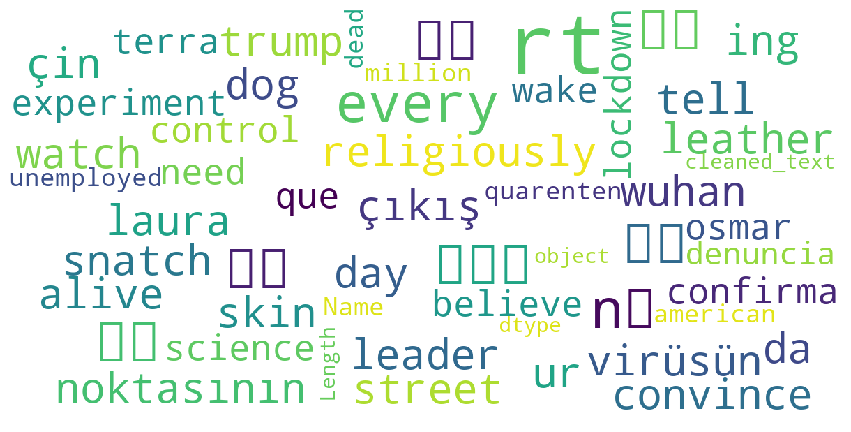

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['cleaned_text'])

In [15]:
# the column data['hashtags'] returns a list of string(s) for each tweet. Build a list of all hashtags in the dataset.
hashtag_list = []
for i in range(0, len(data)):
    # Obtain the current list of hashtags
    curr_hashtag = data.iloc[i, :]['hashtags']
    
    # Extract and append the hashtags to 'hashtag_list':
    for j in range(0, len(curr_hashtag)):
        hashtag_list.append(curr_hashtag[j])
        
# No. of hashtags
print('No. of hashtags used in {} tweets is {}'.format(len(data), len(hashtag_list)))

df_hashtag = pd.DataFrame(
    {'hashtags': hashtag_list}
)
print(df_hashtag.head(20))
print('Shape of df_hashtag is:', df_hashtag.shape)

No. of hashtags used in 1764 tweets is 5808
                hashtags
0                covid19
1      coronaviruscanada
2    chinaliedpeopledied
3             chinavirus
4                cdnpoli
5                kungflu
6             chinavirus
7                  trump
8                chinese
9                  china
10            chinavirus
11         nezamanakadar
12              stayhome
13          chinesevirus
14    chinaliedpeopledie
15            chinavirus
16    chinaliedpeopledie
17            chinavirus
18          chinamustpay
19  chinaliedpeopleadied
Shape of df_hashtag is: (5808, 1)


                    hashtags  counts
205             chinesevirus    1014
183               chinavirus     591
1226              wuhanvirus     355
285              coronavirus     216
151                    china     175
319                  covid19     142
142                 ccpvirus      96
170      chinaliedpeopledied      95
167   chinaliedandpeopledied      59
836                obamagate      53
328                 covid_19      50
175             chinamustpay      49
135                      ccp      48
689                  kungflu      48
1213                   wuhan      46
736             makechinapay      36
1217        wuhancoronavirus      34
727                     maga      33
337                 covidー19      33
318                    covid      32
917                    qanon      30
113             boycottchina      30
1200                     who      29
1232                 wwg1wga      25
139                 ccpchina      24
206           chinesevirus19      24
8

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


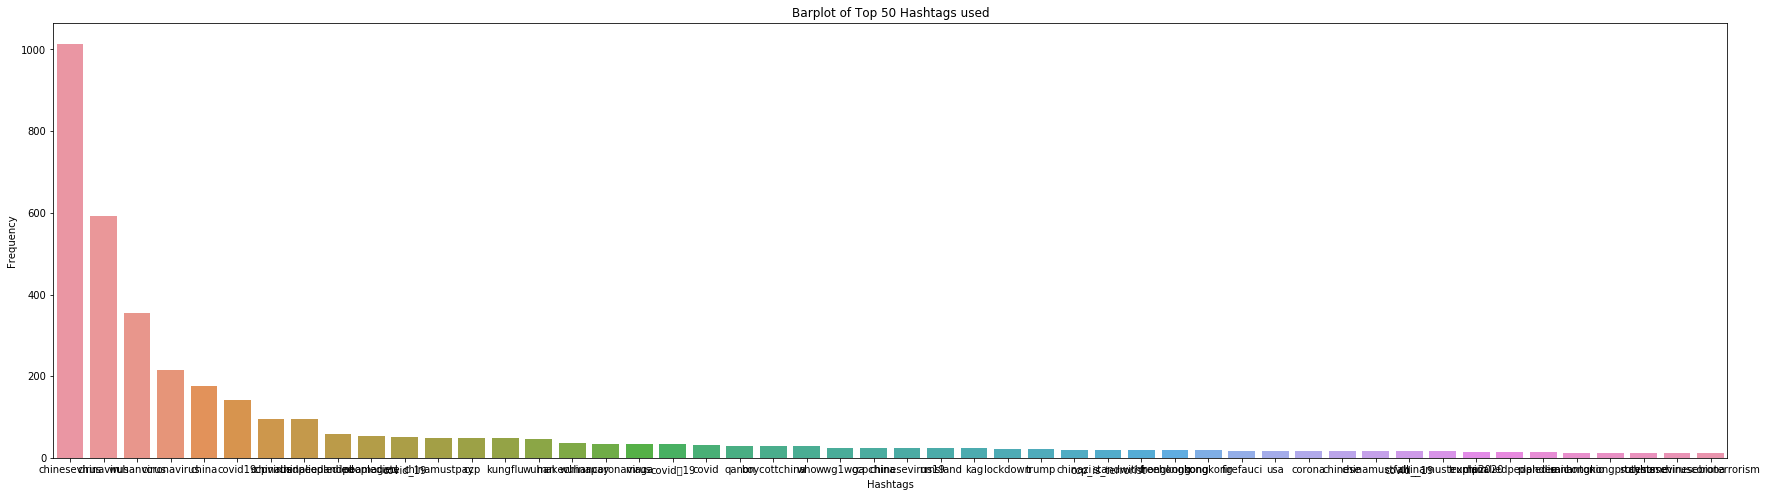

In [16]:
import seaborn as sns

# Define N to be the top number of hashtags
N = 50
top_hashtags = df_hashtag.groupby(['hashtags']).size().reset_index(name = 'counts').sort_values(by = 'counts', ascending = False).head(N)
print(top_hashtags)
# seaborn countplot on the top N hashtags
plt.figure(figsize=(30,8))
sns.set_palette('PuBuGn_d')
sns.barplot(x = 'hashtags', y = 'counts', data = top_hashtags)
plt.title('Barplot of Top ' + str(N) + ' Hashtags used')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.show()

In [19]:
def isNaN(num):
    return num != num

def get_full_name(x):
    if x is None or isNaN(x):
        return None
    else:
        return x['full_name']
data['place_full_name']=data['place'].apply(lambda x: get_full_name(x))

data[data['place_full_name'].apply(lambda x: x is not None)]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords,place_full_name
29,2020-05-01 00:59:19+00:00,1256025374305054720,1256025374305054720,if Kung Fu Panda is A Real Person https://t.co...,False,"[0, 97]","{'hashtags': [{'text': 'ChinaLiedPeopleDied', ...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,kung fu panda real person,tuxtla gtz,"hija, hermana, madre, esposa, y amiga",0.540,0.460,0.000,-0.6908,25,5,"Fort Saskatchewan, Alberta"
32,2020-05-01 04:15:50+00:00,1256074829666627585,1256074829666627584,"@palkisu Man, Palki Sharma is on fire! She is ...",False,"[9, 183]",{'hashtags': [{'text': 'ChinaLiedAndPeopleDied...,"<a href=""http://twitter.com/download/android"" ...",1.255753e+18,1.255753e+18,...,man palki sharma fire absolute delight watch e...,r magaville,✨#qcrushmagaroller qcrush digs👈🏻 youtube chann...,0.246,0.391,0.363,0.4767,73,11,"Halifax, Nova Scotia"
161,2020-05-02 04:09:24+00:00,1256435595817046018,1256435595817046016,Passed? Another virus related to seafood is de...,False,"[0, 76]","{'hashtags': [{'text': 'china', 'indices': [58...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,pass another virus relate seafood develop,n.a,n.a,0.000,1.000,0.000,0.0000,41,6,"Sai Kung District, Hong Kong"
469,2020-05-06 11:12:12+00:00,1257991551088652288,1257991551088652288,Badi ajeeb baat hai jab africa se koi virus fe...,False,"[0, 249]","{'hashtags': [{'text': 'ChineseVirus', 'indice...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,badi ajeeb baat hai jab africa se koi virus fe...,n.a,n.a,0.000,1.000,0.000,0.0000,199,38,"Bhopal, India"
551,2020-05-08 08:13:14+00:00,1258671288006164480,1258671288006164480,It would be a shame if #ChineseVirus began to ...,False,"[0, 52]","{'hashtags': [{'text': 'ChineseVirus', 'indice...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,would shame begin trend,n.a,n.a,0.508,0.492,0.000,-0.4767,23,4,"Franklin Lakes, NJ"
674,2020-05-08 16:05:57+00:00,1258790251197108224,1258790251197108224,Self Defense. #2A Hope he didn’t die of #Chine...,False,"[0, 154]","{'hashtags': [{'text': '2A', 'indices': [14, 1...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,self defense hope didn’t die go begin open tom...,n.a,n.a,0.222,0.455,0.324,-0.0516,74,12,"Nevada, USA"
729,2020-05-08 16:30:30+00:00,1258796430027874304,1258796430027874304,#ChineseVirus\nChina should get the investigat...,False,"[0, 280]","{'hashtags': [{'text': 'ChineseVirus', 'indice...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,\nchina get investigation do wire scroll print...,n.a,n.a,0.048,0.759,0.193,0.6369,185,23,"Gurgaon, India"
773,2020-05-08 16:54:27+00:00,1258802456554803200,1258802456554803200,@RealJamesWoods #ChineseVirus,False,"[16, 29]","{'hashtags': [{'text': 'ChineseVirus', 'indice...","<a href=""http://twitter.com/download/iphone"" r...",1.258618e+18,1.258618e+18,...,,n.a,n.a,0.000,0.000,0.000,0.0000,0,1,"Houston, TX"
1206,2020-05-12 05:51:10+00:00,1260085087858618371,1260085087858618368,Assertive China ....Now GOI should take a note...,False,"[0, 95]","{'hashtags': [{'text': 'ChineseVirus', 'indice...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,assertive china goi take note bleame china,n.a,n.a,0.000,1.000,0.000,0.0000,42,7,"Kolkata, India"
1353,2020-05-15 17:46:07+00:00,1261352174295977984,1261352174295977984,#ChineseVirus https://t.co/L7VLLRESyq,False,"[0, 13]","{'hashtags': [{'text': 'ChineseVirus', 'indice...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,,n.a,n.a,0.000,0.000,0.000,0.0000,0,1,"Alexandria, VA"


In [18]:
data[data['coordinates'].apply(lambda x: x is not None)]


,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords,place_full_name
